In [136]:
import sys
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [137]:
from coco.job import Job

In [140]:
current_job = Job.from_name("nyu_depth")

state_run
phase_train
1


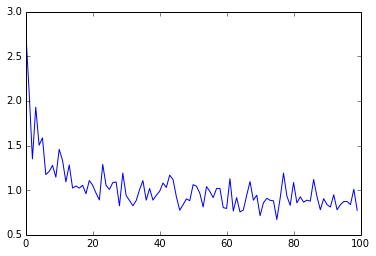

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Refresh job
current_job.load()
data = current_job.data

print data["state"]
print data["phase"]
print data["epoch"]

if "train_losses" in data:
    train_losses = np.array(data["train_losses"]).squeeze()
    plt.plot(train_losses[:])
    plt.show()

if "val_losses" in data:
    val_losses = np.array(data["val_losses"]).squeeze()
    plt.plot(val_losses)
    plt.show()

    w = 40
    l = []
    for i in range(0,len(val_losses),w):
        l.append((val_losses[i:i+w].mean()))

    plt.plot(l)
    plt.show()

In [143]:
import sys
import os
import inspect

import numpy as np

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from coco.database_reader import HDF5DatabaseReader
from coco.multiprocess import MultiProcessor
from coco.architectures.depth import DepthPredictionScaffolder, ResidualDepth
from coco.transformations import zoom_rotate, random_rgb, random_crop, normalize_images, downsample, clip, noise, exp

global mean
mean = np.load("/data/data/nyu_v2.npy")


def process_val(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

train_db = "/data/data/nyu_v2.hdf5"
val_db = "/data/data/test_v2.hdf5"

batch_size = 64

val_reader = HDF5DatabaseReader(label_key="depths")
val_reader.setup_read(val_db)

val_processor = MultiProcessor(
    val_reader, func=process_val, batch_size=batch_size)

scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=0.5)
scaffolder.compile()
scaffolder.load("/data/data/resunet.npz")

DEBUG:coco.multiprocess:Creating multiprocessor instance with batchsize=64 and queue_size=20
DEBUG:coco.nn:Number of parameters for output 'None': 11797793
INFO:coco.nn:Compiling inference function.


ValueError: mismatch: parameter has shape (32, 64, 1, 1) but value to set has shape (64, 64, 1, 1)